# AR/MA processes as as state-space models

In [72]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
from matplotlib.gridspec import GridSpec

In [5]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (7.2, 4.0)


sns.set_palette("colorblind")

In [158]:
def create_cbar_mappable(cmap, vmin, vmax):
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    return mappable


def create_cbar_discrete_mappable(cmap, boundaries):
    boundaries_extend = [*boundaries, boundaries[-1] + 1]
    norm = mpl.colors.BoundaryNorm(boundaries=boundaries_extend, ncolors=cmap.N, clip=True)
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    ticks = []
    for iinit, iend in zip(boundaries_extend[:-1], boundaries_extend[1:]):
        midpoint = (iinit + iend) / 2
        ticks.append(midpoint)

    return mappable, ticks

In [6]:
def step_ssm(state, key, F, H, T, R):
    theta, noise = state
    # Build next state
    theta = F @ theta + T @ noise
    noise = jax.random.normal(key) * R
    state_next = (theta, noise)
    
    # Build observation 
    y = H @ theta + noise

    out = {
        "y": y,
        "theta": theta
    }
    
    return state_next, out


def run_ssm(key, F, H, T, R, n_steps):
    """
    Run sample of a state-space model
    with initial zero-valued latent process
    """
    dim_latent = F.shape[0]
    theta_init = jnp.zeros((dim_latent, 1))
    noise_init = jnp.eye(1) * 0.0
    state_init = (theta_init, noise_init) # latent and error term

    keys = jax.random.split(key, n_steps)
    step = partial(step_ssm, F=F, H=H, T=T, R=R)
    _, hist = jax.lax.scan(step, state_init, keys)
    hist = jax.tree.map(jnp.squeeze, hist)
    return hist

##  MA(m) process

A time series ${\bf y}_{1:t}$ is said to be a $m$-th order moving average (MA) process
if there are known $p\times p$ matrices ${\bf A}_1, \ldots, {\bf A}_m$ such that
$$
    y_t = \sum_{j=1}^m {\bf A}_{t-j}\,e_j + e_t
$$

In state-space form, the AR(m) process is given by
$$
\begin{aligned}
    \Theta_{t} &= {\bf F}_{\rm MA}\,\Theta_{t-1} + {\bf T}_m\,{\bf e}_{t-1}\\
    {\bf y}_t &= {\bf H}_{\rm MA}\,\Theta_t + {\bf e}_t
\end{aligned}
$$
with
$$
    {\bf F}_\text{MA} =
    \begin{bmatrix}
    {\bf 0} & \ldots & {\bf 0} & {\bf 0}\\
    {\bf I} & \ldots & {\bf 0} & {\bf 0} \\
    {\bf 0} & \ldots & {\bf I} & {\bf 0}
    \end{bmatrix}
$$
and ${\bf u}_t = {\bf T}_m\,{\bf e}_t$ for ${\bf T}_m$ given by
$$
    {\bf T}_m =
    \begin{bmatrix}
    {\bf I}\\
    {\bf 0} \\
    \vdots \\
    {\bf 0}
    \end{bmatrix}
$$

In [243]:
def build_ma_components(H_ma):
    m = len(H_ma.ravel())
    F_ma = jnp.diagflat(jnp.ones(m-1), k=-1)

    Tm = jnp.zeros(m).at[0].set(1)[:, None]
    return F_ma, Tm

### Building blocks

In [64]:
A = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0])[None, :]

F_ma, Tm = build_ma_components(A)

### Sampling

In [65]:
n_steps = 100
key = jax.random.PRNGKey(3141)
R = jnp.eye(1) * 0.1 ** 2 # measurement noise
hist = run_ssm(key, F_ma, A, Tm, R, n_steps)

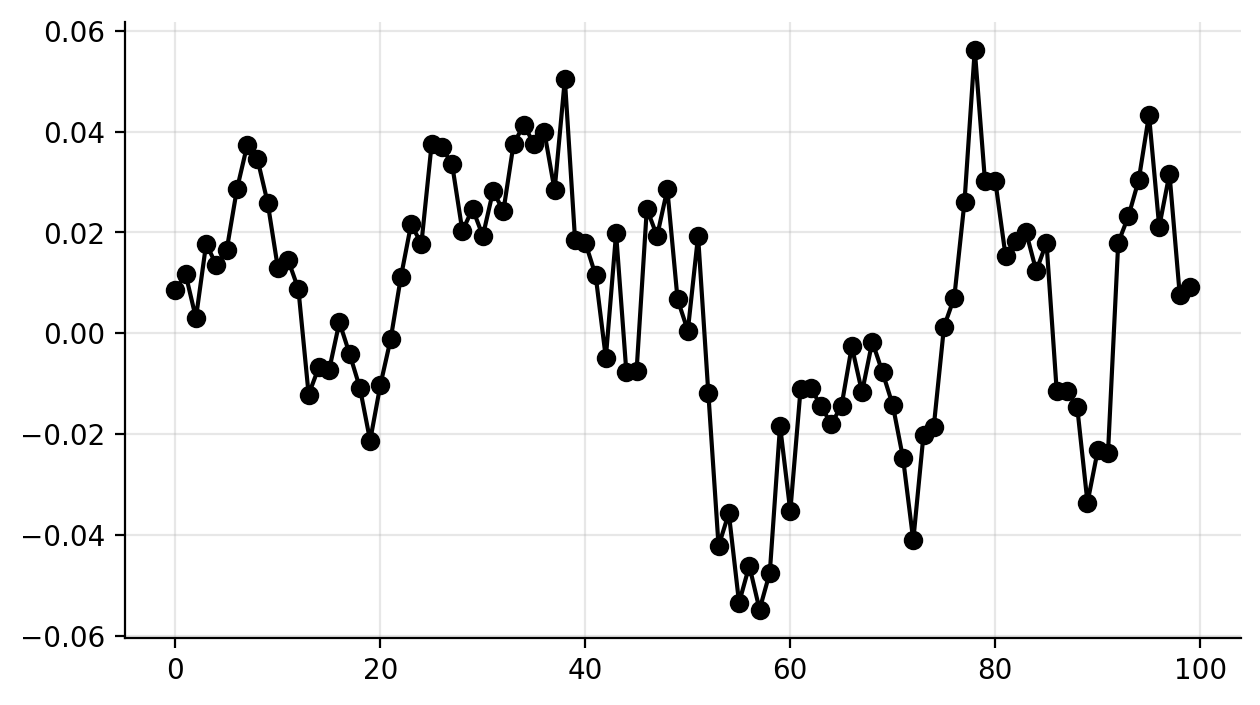

In [66]:
plt.plot(hist["y"], c="black", marker="o")
plt.grid(alpha=0.3)

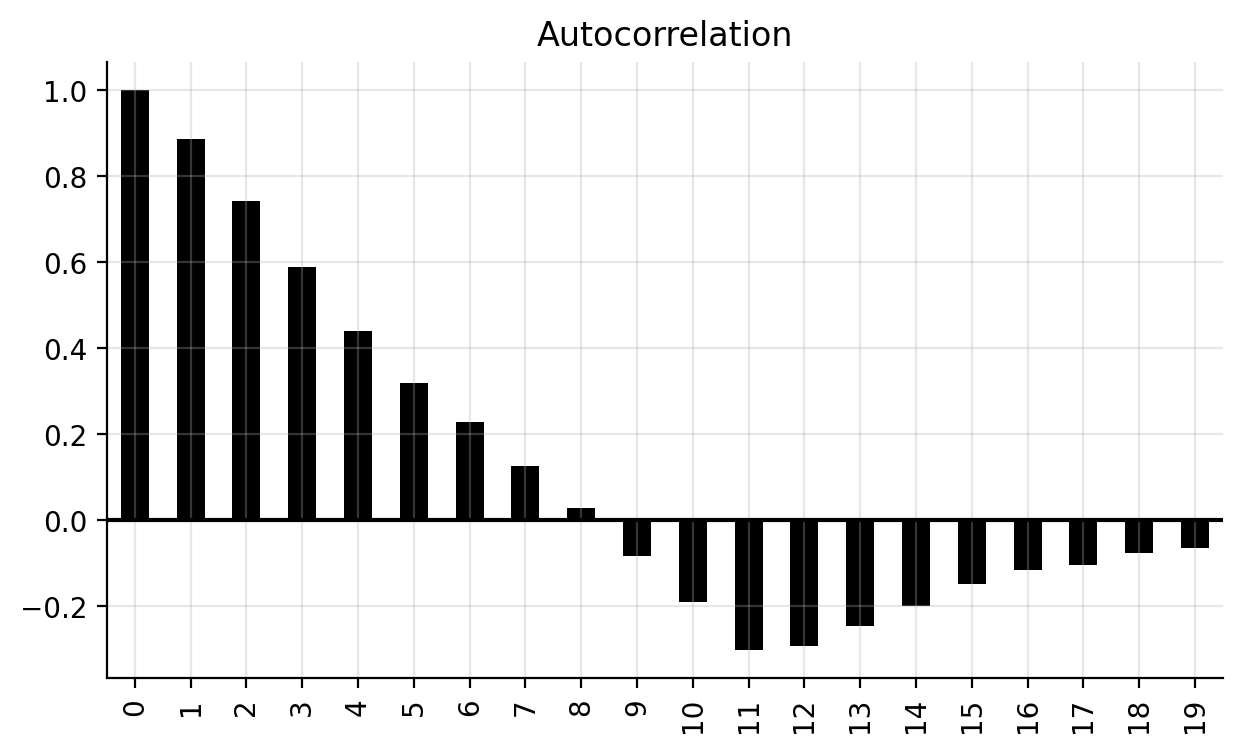

In [172]:
Y = pd.DataFrame(hist["y"])
for i in range(1, 20):
    Y[i] = Y[0].shift(i)
Y.corr()[0].plot(kind="bar", color="black")
plt.title("Autocorrelation")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)

## MA(1) with varying number of parameters

In [173]:
n_values = 10
ma_sims = {}
n_steps = 200
H_ma_values = jnp.linspace(-1, 1, n_values)

for b in H_ma_values:
    H_ma = jnp.array([b])
    F_ma, T_m = build_ma_components(H_ma)
    hist = run_ssm(key, F_ma, H_ma, T_m, R, n_steps)
    ma_sims[float(b)] = hist["y"]
ma_sims = pd.DataFrame(ma_sims)

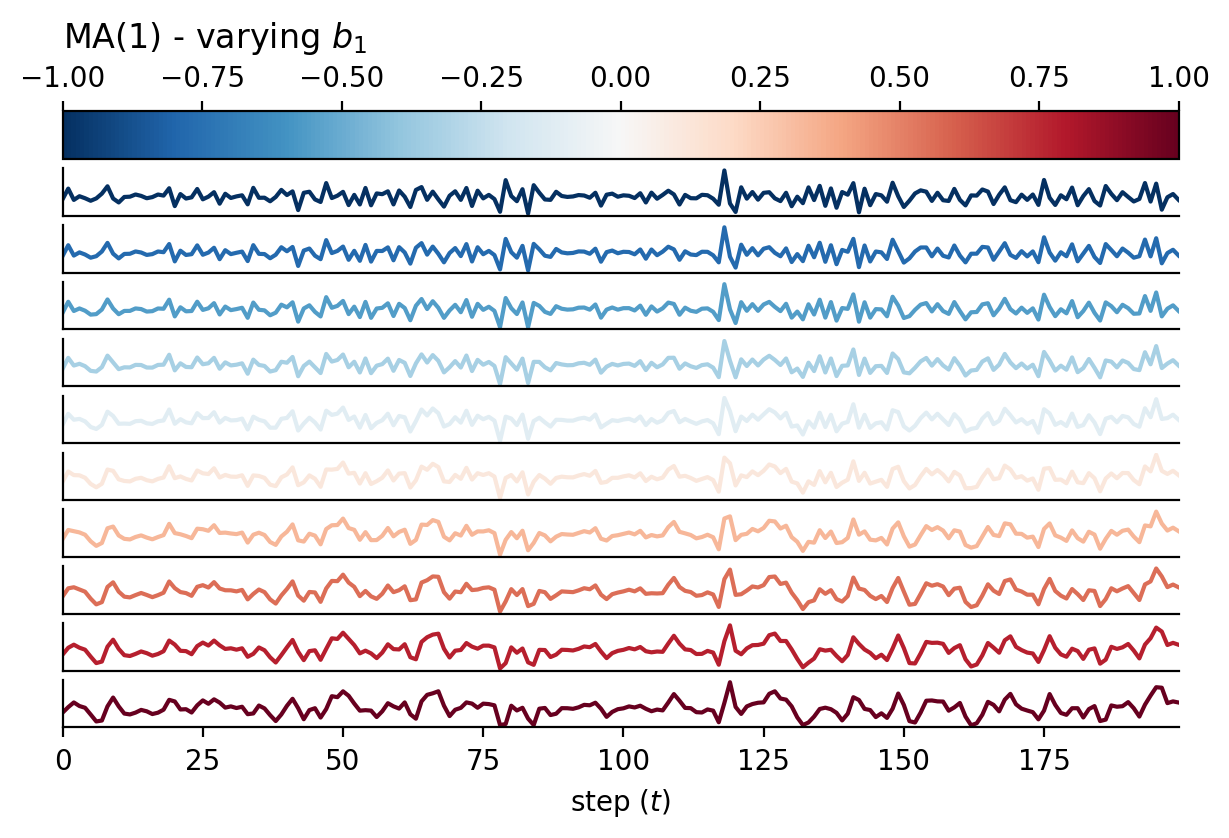

In [174]:
fig = plt.figure()
gs = GridSpec(n_values + 1, 1)

cmap = plt.cm.RdBu_r
mappable = create_cbar_mappable(cmap, H_ma_values.min(), H_ma_values.max())

ax_cbar = fig.add_subplot(gs[0])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation="horizontal")
ax_cbar.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax_cbar.set_title("MA(1) - varying $b_1$", loc="left")

colors = cmap(jnp.linspace(0, 1, n_values))
for i, (c, b) in enumerate(zip(colors, ma_sims)):
    ax = fig.add_subplot(gs[i+1])
    
    ax.set_yticks([])
    ax.plot(ma_sims[b], c=c)
    ax.set_xlim(0, n_steps-1)
    if i != n_values-1:
        ax.set_xticks([])

ax.set_xlabel("step ($t$)")
plt.savefig("ma1-sample.png", dpi=300, bbox_inches="tight")

In [175]:
lags = np.arange(1, 10)

Text(0, 0.5, 'autocorrelation')

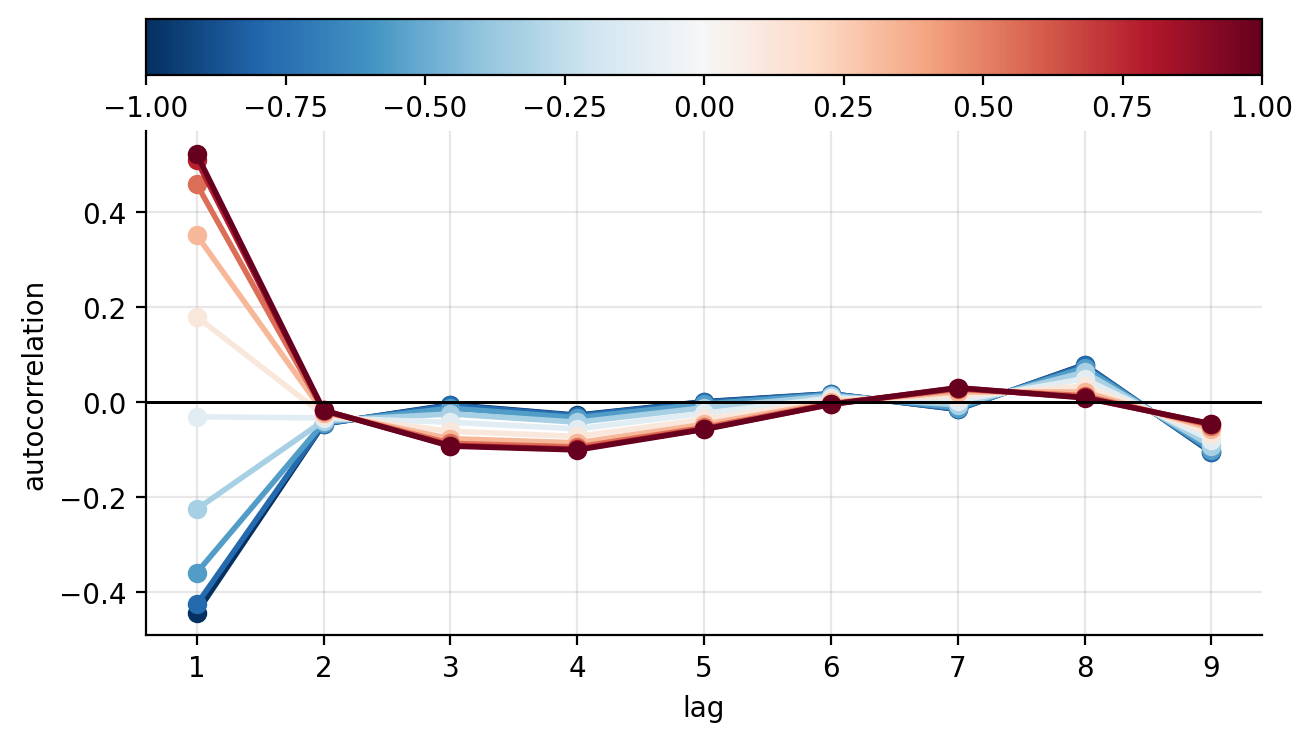

In [177]:
# fig, axs = plt.subplots(n_values, 1, sharex=True, figsize=(7.2, 5.0))
fig = plt.figure()
gs = GridSpec(2, 1, height_ratios=[0.1, 0.9])

ax = fig.add_subplot(gs[1])
ax_cbar = fig.add_subplot(gs[0])

cmap = plt.cm.RdBu_r
mappable = create_cbar_mappable(cmap, H_ma_values.min(), H_ma_values.max())
plt.colorbar(mappable, cax=ax_cbar, orientation="horizontal")
colors = cmap(jnp.linspace(0, 1, n_values))

for c, b in zip(colors, ma_sims):
    sim = ma_sims[b]
    autocorrs = [sim.autocorr(lag) for lag in lags]
    ax.plot(lags, autocorrs, color=c, linewidth=2, marker="o")
    ax.axhline(y=0.0, c="black", linewidth=1)
    
    # ax.set_yticks([])
    # ax.plot(ar_sims[a], c=c)
    ax.grid(alpha=0.3)
ax.set_xlabel("lag")
ax.set_ylabel("autocorrelation")
# plt.suptitle("AR($1$) with varying $a_1$")

## MA(1) with increasing dimension

In [178]:
n_values = 10
ma_sims = {}
n_steps = 200
# H_ma_values = jnp.linspace(-1, 1, n_values)
H_ma_lenghts = jnp.arange(n_values) + 1
b = 1.0
for ell in H_ma_lenghts:
    H_ma = jnp.ones(ell) * b
    F_ma, T_m = build_ma_components(H_ma)
    hist = run_ssm(key, F_ma, H_ma, T_m, R, n_steps)
    ma_sims[int(ell)] = hist["y"]
ma_sims = pd.DataFrame(ma_sims)

Text(0.5, 0, 'step ($t$)')

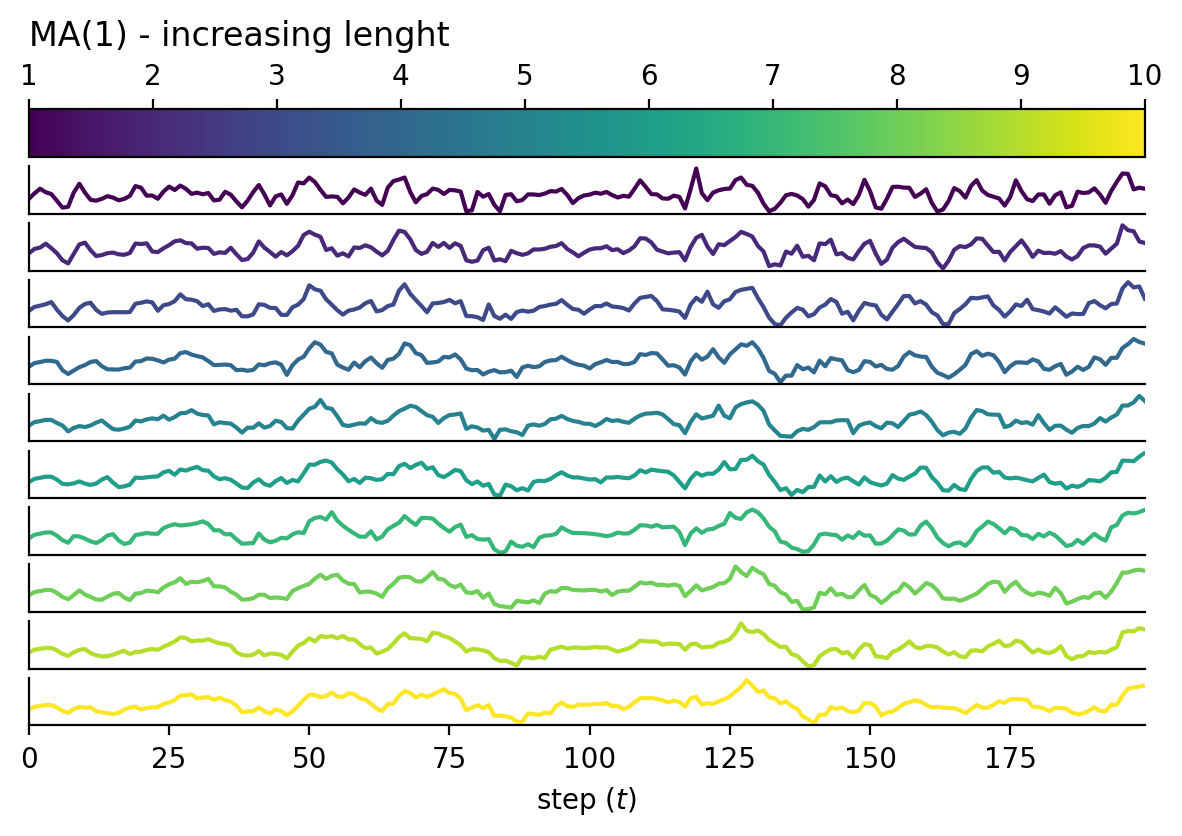

In [179]:
fig = plt.figure()
gs = GridSpec(n_values + 1, 1)

cmap = plt.cm.viridis
mappable = create_cbar_mappable(cmap, H_ma_lenghts.min(), H_ma_lenghts.max())

ax_cbar = fig.add_subplot(gs[0])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation="horizontal")
ax_cbar.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax_cbar.set_title("MA(1) - increasing lenght", loc="left")

colors = cmap(jnp.linspace(0, 1, n_values))
for i, (c, b) in enumerate(zip(colors, ma_sims)):
    ax = fig.add_subplot(gs[i+1])
    
    ax.set_yticks([])
    ax.plot(ma_sims[b], c=c)
    ax.set_xlim(0, n_steps-1)
    if i != n_values-1:
        ax.set_xticks([])

ax.set_xlabel("step ($t$)")
# plt.savefig("ma1-sample.png", dpi=300, bbox_inches="tight")

### Autocorrelation plot

In [180]:
lags = np.arange(1, 30)

Text(0, 0.5, 'autocorrelation')

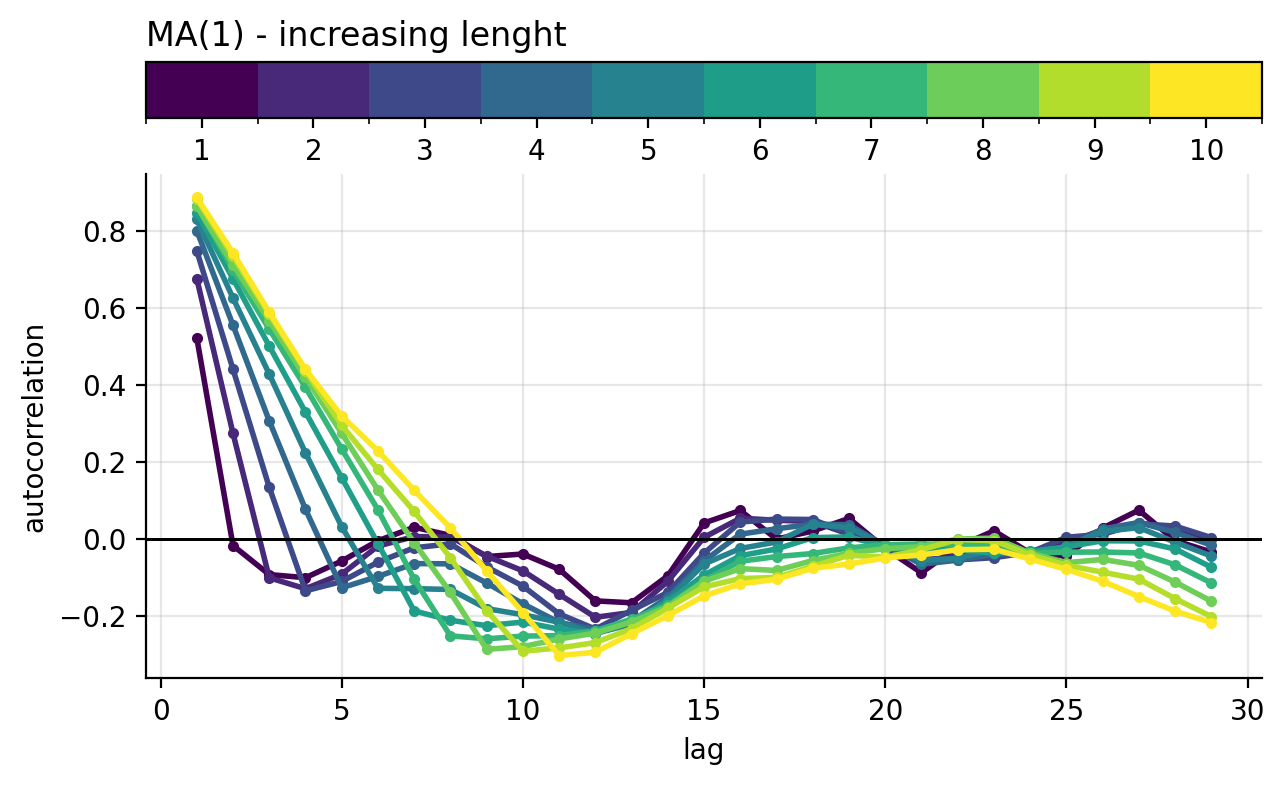

In [181]:
# fig, axs = plt.subplots(n_values, 1, sharex=True, figsize=(7.2, 5.0))
fig = plt.figure()
gs = GridSpec(2, 1, height_ratios=[0.1, 0.9])

ax = fig.add_subplot(gs[1])
ax_cbar = fig.add_subplot(gs[0])

cmap = plt.cm.viridis
mappable, ticks = create_cbar_discrete_mappable(cmap, H_ma_lenghts)
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation="horizontal")
ax_cbar.set_title("MA(1) - increasing lenght", loc="left")
cbar.set_ticks(ticks, labels=H_ma_lenghts)

colors = cmap(jnp.linspace(0, 1, n_values))

for c, b in zip(colors, ma_sims):
    sim = ma_sims[b]
    autocorrs = [sim.autocorr(lag) for lag in lags]
    ax.plot(lags, autocorrs, color=c, linewidth=2, marker="o", markersize=3)
    ax.axhline(y=0.0, c="black", linewidth=1)
    
    # ax.set_yticks([])
    # ax.plot(ar_sims[a], c=c)
    ax.grid(alpha=0.3)
ax.set_xlabel("lag")
ax.set_ylabel("autocorrelation")
# plt.suptitle("AR($1$) with varying $a_1$")

---

## AR(r) process

An $r$th order autoregressive (AR) process has the form
$$
    y_t = \sum_{j=1}^r {\bf B}_j\,y_{t-j} + e_t
$$
with ${\bf B}_1, \ldots, {\bf B}_r$ known coefficient matrices, $e_{1:t}$ zero-mean blockwise uncorrelated random vectors
and $y_{-1} = \ldots = y_{-r} = 0$.

In state-space form, the MA(p) process is given by
$$
\begin{aligned}
    {\bf y}_t &= {\bf H}_{\rm AR}{\bf z}_t + {\bf e}_t\\
    \Theta_{t+1} &= {\bf F}_{\rm AR}{\bf z}_t + {\bf T}_r\,{\bf e}_t
\end{aligned}
$$

with
$$
    {\bf F}_\text{AR} =
    \begin{bmatrix}
    {\bf B}_1 & \ldots & {\bf B}_{r-1} & {\bf B}_r\\
    {\bf I} & \ldots & {\bf 0} & {\bf 0} \\
    {\bf 0} & \ldots & {\bf I} & {\bf 0}
    \end{bmatrix}
$$
and
$$
    {\bf H}_{\rm MA} =
    \begin{bmatrix}
    {\bf B}_1, \ldots, {\bf B}_r
    \end{bmatrix}
$$

In [238]:
def build_ar_components(H_ar):
    r = len(H_ar.ravel())
    F_ar = jnp.diagflat(jnp.ones(r-1), k=-1)
    F_ar = F_ar.at[0].set(H_ar)
    T_r = jnp.zeros(r).at[0].set(1)[:, None]
    return F_ar, T_r

In [183]:
n_steps = 200
key = jax.random.PRNGKey(314)
R = jnp.eye(1) * 0.1 ** 2 # measurement noise

### Sampling

In [184]:
H_ar = jnp.array([1.0, -1.0, 0.3])
F_ar, T_r = build_ar_components(H_ar)
hist = run_ssm(key, F_ar, H_ar, T_r, R, n_steps)

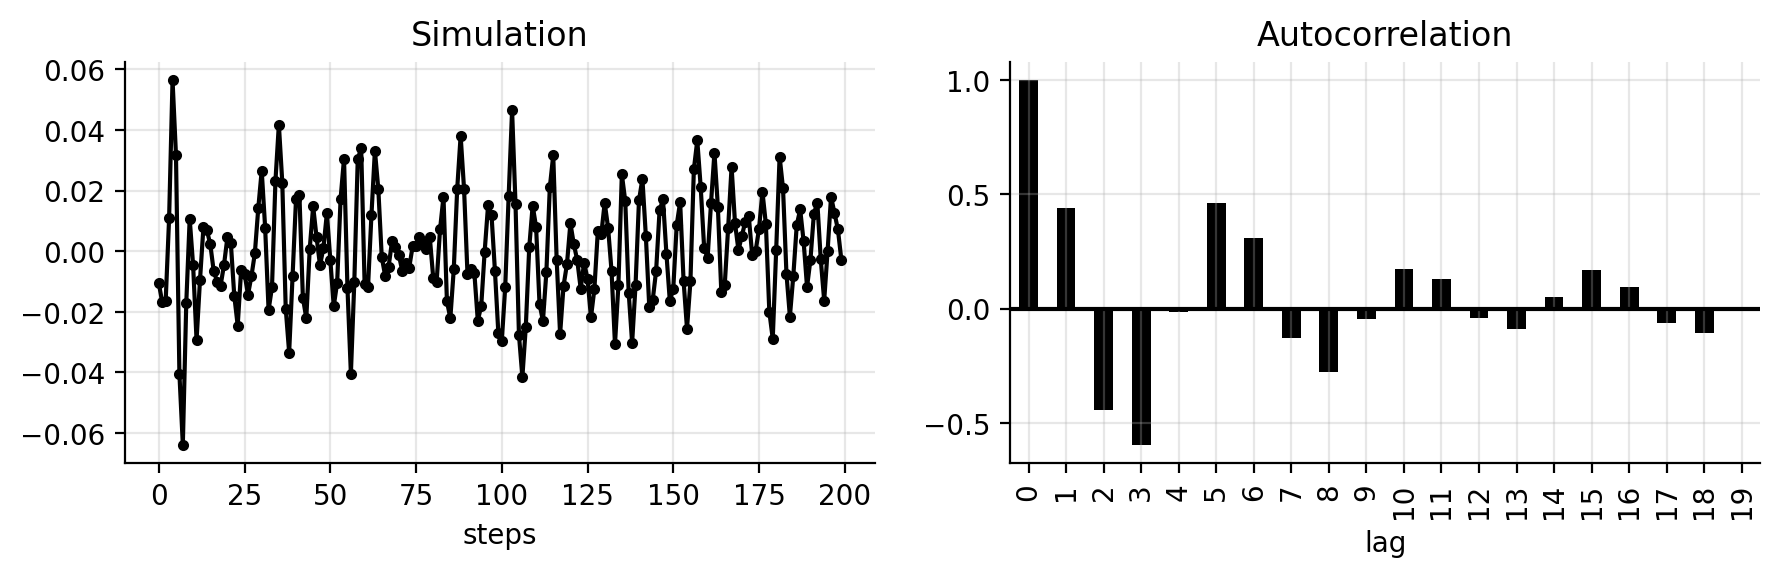

In [185]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

ax[0].plot(hist["y"], c="black", marker="o", markersize=3)
ax[0].grid(alpha=0.3)
ax[0].set_title("Simulation")
ax[0].set_xlabel("steps")

Y = pd.DataFrame(hist["y"])
for i in range(1, 20):
    Y[i] = Y[0].shift(i)
Y.corr()[0].plot(kind="bar", color="black", ax=ax[1])
ax[1].axhline(y=0, c="black")
ax[1].set_title("Autocorrelation")
ax[1].set_xlabel("lag")
ax[1].grid(alpha=0.3)
plt.tight_layout()

## AR(1) with varying number of parameters

In [204]:
n_values = 10
ar_sims = {}
n_steps = 200
H_ar_values = jnp.linspace(-1, 1, n_values)

for a in H_ar_values:
    H_ar = jnp.array([a])
    F_ar, T_r = build_ar_components(H_ar)
    hist = run_ssm(key, F_ar, H_ar, T_r, R, n_steps)
    ar_sims[float(a)] = hist["y"]

ar_sims = pd.DataFrame(ar_sims)

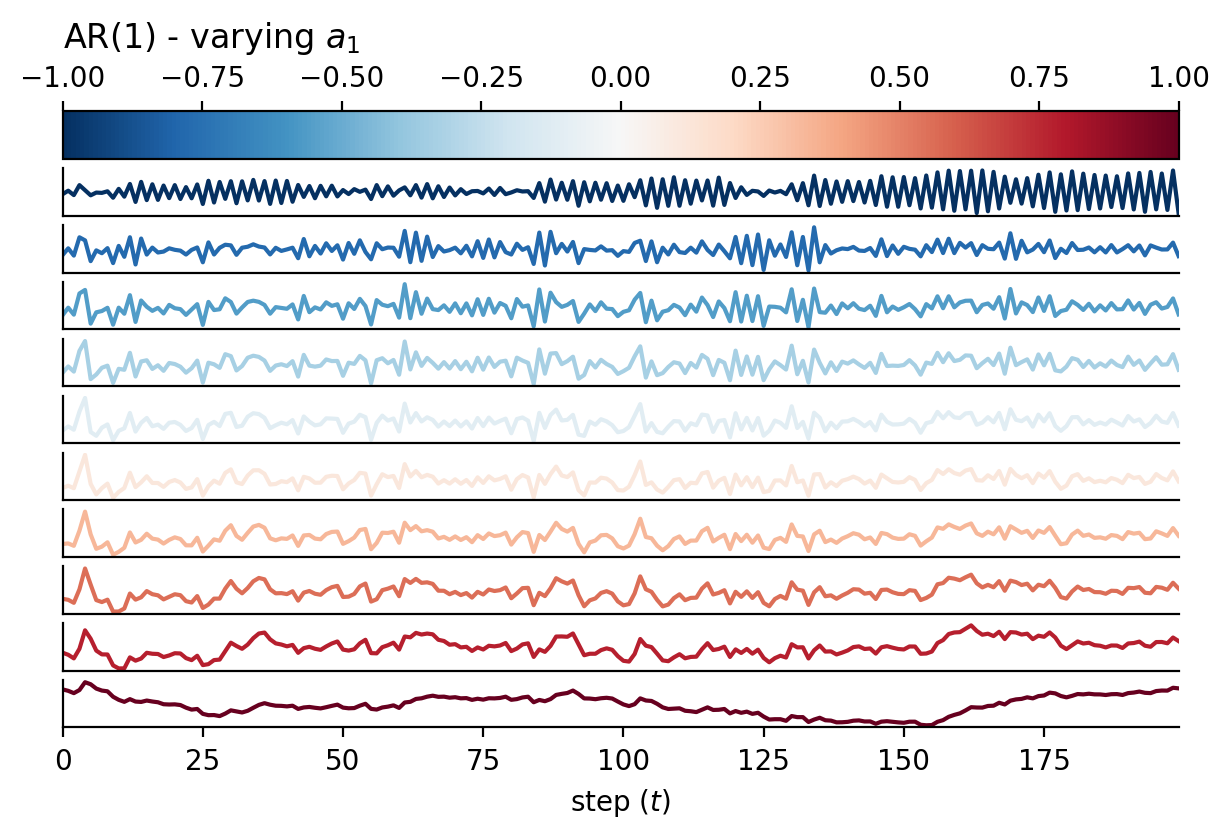

In [205]:

cmap = plt.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=H_ar_values.min(), vmax=H_ar_values.max())
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
gs = GridSpec(n_values + 1, 1)

ax_cbar = fig.add_subplot(gs[0])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation="horizontal")
ax_cbar.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax_cbar.set_title("AR(1) - varying $a_1$", loc="left")

colors = cmap(jnp.linspace(0, 1, n_values))
for i, (c, a) in enumerate(zip(colors, ar_sims)):
    ax = fig.add_subplot(gs[i+1])
    
    ax.set_yticks([])
    ax.plot(ar_sims[a], c=c)
    ax.set_xlim(0, n_steps-1)
    if i != n_values-1:
        ax.set_xticks([])

ax.set_xlabel("step ($t$)")
plt.savefig("ar1-sample.png", dpi=300, bbox_inches="tight")

### Autocorrelation

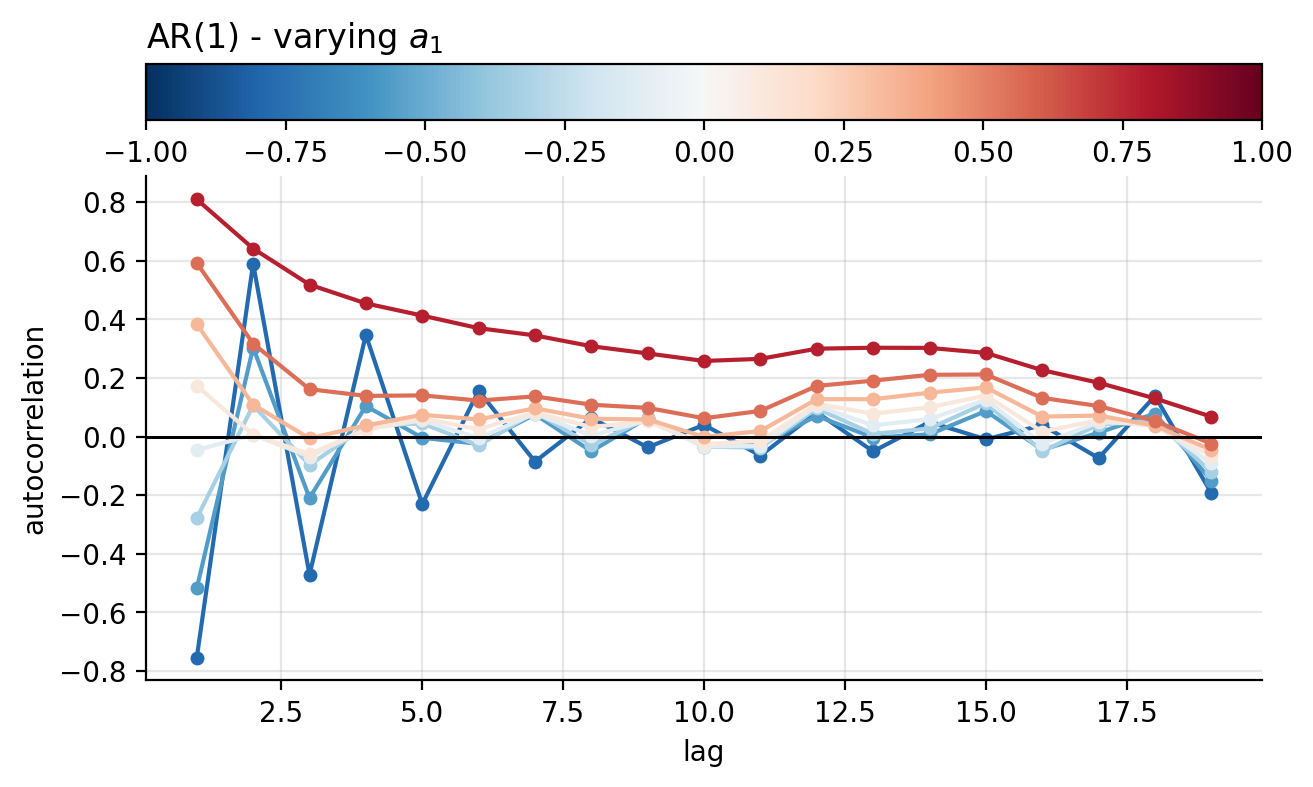

In [215]:
lags = np.arange(1, 20)

# fig, axs = plt.subplots(n_values, 1, sharex=True, figsize=(7.2, 5.0))
fig = plt.figure()
gs = GridSpec(2, 1, height_ratios=[0.1, 0.9])

ax = fig.add_subplot(gs[1])
ax_cbar = fig.add_subplot(gs[0])

cmap = plt.cm.RdBu_r
mappable = create_cbar_mappable(cmap, H_ar_values.min(), H_ar_values.max())
plt.colorbar(mappable, cax=ax_cbar, orientation="horizontal")
colors = cmap(jnp.linspace(0, 1, n_values))
ax_cbar.set_title("AR(1) - varying $a_1$", loc="left")

for c, b in zip(colors, ar_sims):
    if (b == 1) or (b==-1):
        continue
    sim = ar_sims[b]
    autocorrs = [sim.autocorr(lag) for lag in lags]
    ax.plot(lags, autocorrs, color=c, marker="o", markersize=4)
    ax.axhline(y=0.0, c="black", linewidth=1)
    
    # ax.set_yticks([])
    # ax.plot(ar_sims[a], c=c)
    ax.grid(alpha=0.3)
ax.set_xlabel("lag")
ax.set_ylabel("autocorrelation")
# plt.suptitle("AR($1$) with varying $a_1$")
plt.savefig("ar1-sample-autocorr.png", dpi=300, bbox_inches="tight")

## ARMA(r,m) processs

In [233]:
def build_arma_components(H_ar, H_ma):
    F_ar, T_ar = build_ar_components(H_ar)
    F_ma, T_ma = build_ma_components(H_ma)

    r, m = len(T_ar), len(T_ma)
    F_arma = jnp.zeros((r + m, r + m))
    F_arma = F_arma.at[:r,:r].set(F_ar)
    F_arma = F_arma.at[r:, r:].set(F_ma)

    H_arma = jnp.concat([H_ar, H_ma])

    T_arma = jnp.r_[T_ar, T_ma]
    return H_arma, F_arma, T_arma

In [337]:
H_ar = jnp.array([-0.2, 0.3])
H_ma = jnp.ones(20)

H_arma, F_arma, T_arma = build_arma_components(H_ar, H_ma)

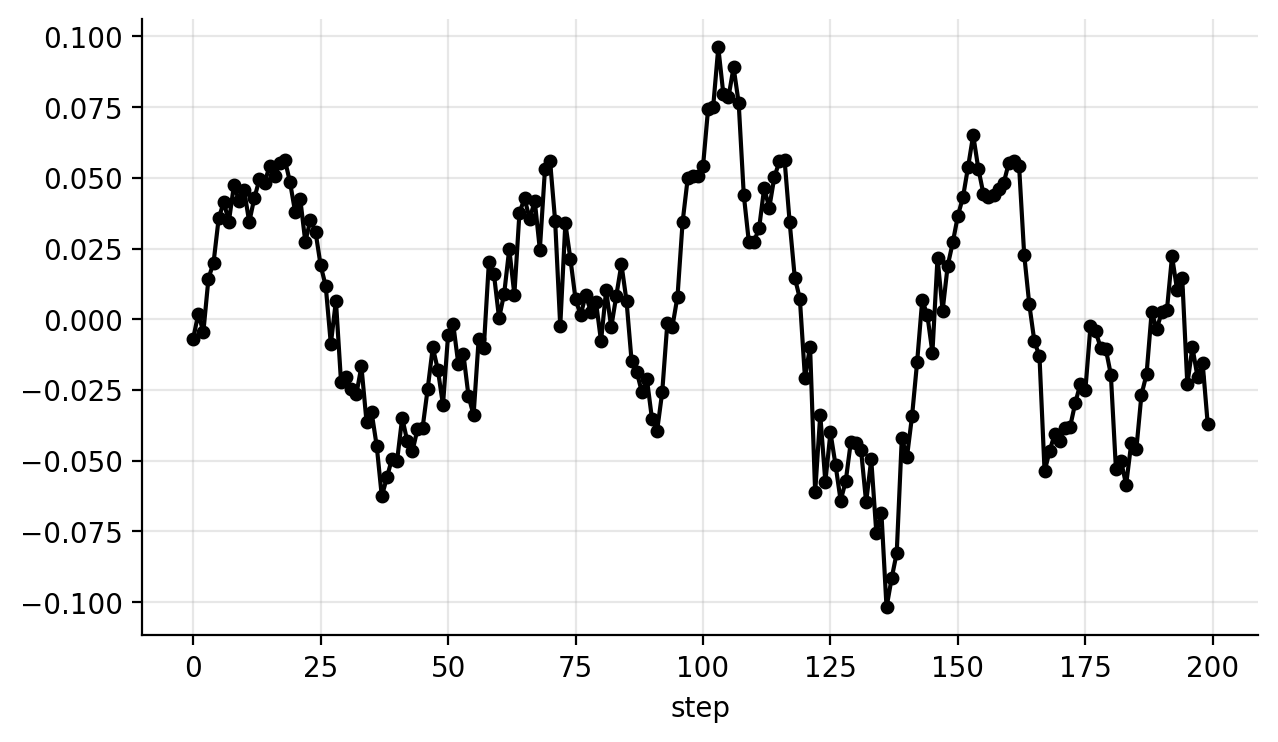

In [341]:
key = jax.random.PRNGKey(314159)
hist = run_ssm(key, F_arma, H_arma, T_arma, R, n_steps)

plt.plot(hist["y"], c="black", marker="o", markersize=4)
plt.xlabel("step")
plt.grid(alpha=0.3)